# Check out database image offerings

In [1]:
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
import os

In [86]:
# Import the function to get connect to the db
from snowexsql.db import get_db
# Import our class for the points, layer, image tables
from snowexsql.data import PointData, LayerData, ImageData

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

Check out types

In [3]:
result = session.query(ImageData.type).distinct().all()
print('Available types = {}'.format(', '.join([r[0] for r in result])))

# # Import a useful function to format that data into a dataframe
# from snowexsql.conversions import query_to_geopandas

# # Import some tools to build dates 
# from datetime import date

Available types = swe, DEM, insar amplitude, insar correlation, depth, insar interferogram real, insar interferogram imaginary


Plot some results

In [4]:
# import this to use define sql functions (e.g. postgis!)
from sqlalchemy.sql import func 

# Import this to convert to a rasterio object for easy plotting
from snowexsql.conversions import raster_to_rasterio 

# Import a convenient function to plot with 
from rasterio.plot import show

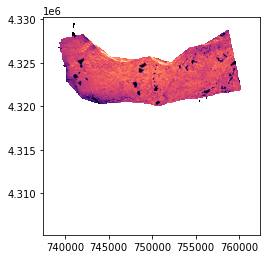

In [5]:
# Remember in the query parentheses is what we get back, in this case were asking for the raster data as a geotiff
result = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.type == 'swe').limit(1).all()

# Now make it more available as a python object 
datasets = raster_to_rasterio(session, result)

# Plot the georeferenced image 
show(datasets[0], vmax=0.4, vmin=0, cmap='magma')

# Close the dataset
datasets[0].close()

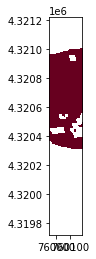

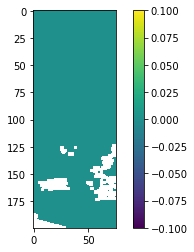

In [6]:

# Remember in the query parentheses is what we get back, in this case were asking for the raster data as a geotiff
result = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.type == 'depth').limit(1).all()

# Now make it more available as a python object 
datasets = raster_to_rasterio(session, result)

# Plot the georeferenced image 
show(datasets[0], 
     vmin=0, vmax=0.1, 
     cmap='RdBu')

a=datasets[0].read()
plt.imshow(a[0][100:300, :])
plt.colorbar()

# Close the dataset
datasets[0].close()

### No snow depths?

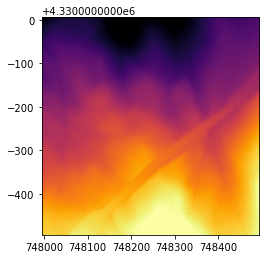

In [7]:
# Remember in the query parentheses is what we get back, in this case were asking for the raster data as a geotiff
result = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.type == 'DEM').limit(1).all()

# Now make it more available as a python object 
datasets = raster_to_rasterio(session, result)

# Plot the georeferenced image 
show(datasets[0],
     vmin = np.nanpercentile(datasets[0].read(), 2),
     vmax = np.nanpercentile(datasets[0].read(), 98),
     cmap='inferno')


# Close the dataset
datasets[0].close()

Check out surveyors

In [8]:
results = session.query(ImageData.surveyors).distinct().all()
print(results)

[('USGS',), ('UAVSAR team, JPL',), ('ASO Inc.',)]


---

Combine into a single query for more info

In [9]:
results = session.query(ImageData.type, 
                        ImageData.instrument, 
                        ImageData.description, 
                        ImageData.surveyors, 
                        func.ST_PixelWidth(ImageData.raster)
                       ).filter(ImageData.surveyors != "UAVSAR team, JPL").distinct().all()

for r in results:
    for line in r:
        print(line)
    print('\n')
# res = max([r[1] for r in results])
# res = (res,res)
# print('Using a resolution of {} m from {}'.format(res[0], aso_depth[0][0]))

swe
lidar
50m product
ASO Inc.
50.000101089121436


depth
lidar
3m snow depth product
ASO Inc.
3.000000000007304


DEM
lidar
US Geological Survey 1m snow off DEM from the 3DEP
USGS
1.0




In [10]:
results = session.query(PointData.type, 
                        PointData.instrument, 
                        PointData.surveyors, 
                       ).filter(PointData.type=='depth').distinct().all()

for r in results:
    for line in r:
        print(line)
    print('\n')
# res = max([r[1] for r in results])
# res = (res,res)
# print('Using a resolution of {} m from {}'.format(res[0], aso_depth[0][0]))

depth
mesa
None


depth
pit ruler
None


depth
camera
Catherine Breen, Cassie Lumbrazo


depth
magnaprobe
None


depth
pulse EKKO Pro multi-polarization 1 GHz GPR
Tate Meehan




In [12]:
from snowexsql.conversions import query_to_geopandas

In [71]:
df.shape

(4390, 23)

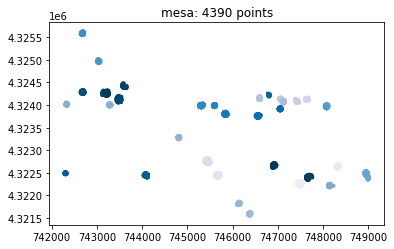

In [75]:
q = session.query(PointData).filter(
    PointData.type == 'depth').filter(
    PointData.instrument == 'mesa'
)
df = query_to_geopandas(q, engine)
df.plot(marker='.', cmap='PuBu')
plt.title(f'{df.loc[0].instrument}: {df.shape[0]} points');

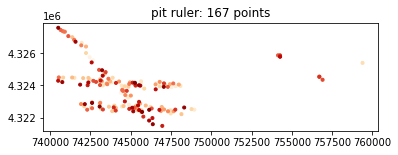

In [76]:
q = session.query(PointData).filter(
    PointData.type == 'depth').filter(
    PointData.instrument == 'pit ruler'
)
df = query_to_geopandas(q, engine)
df.plot(marker='.', cmap='OrRd')
plt.title(f'{df.loc[0].instrument}: {df.shape[0]} points');

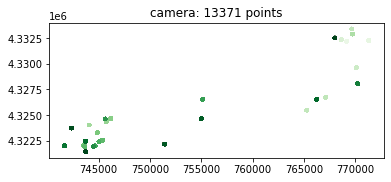

In [78]:
q = session.query(PointData).filter(
    PointData.type == 'depth').filter(
    PointData.instrument == 'camera'
)
df = query_to_geopandas(q, engine)
df.plot(marker='.', cmap='Greens')
plt.title(f'{df.loc[0].instrument}: {df.shape[0]} points');

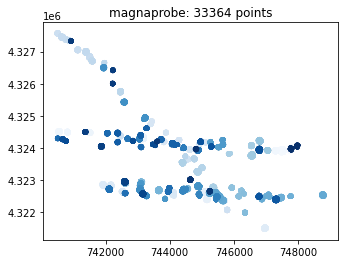

In [80]:
q = session.query(PointData).filter(
    PointData.type == 'depth').filter(
    PointData.instrument == 'magnaprobe'
)
df = query_to_geopandas(q, engine)
df.plot(marker='.', cmap='Blues')
plt.title(f'{df.loc[0].instrument}: {df.shape[0]} points');

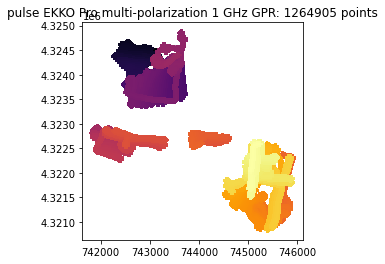

In [81]:
q = session.query(PointData).filter(
    PointData.type == 'depth').filter(
    PointData.instrument == 'pulse EKKO Pro multi-polarization 1 GHz GPR'
)
df = query_to_geopandas(q, engine)
df.plot(marker='+', cmap='inferno')
plt.title(f'{df.loc[0].instrument}: {df.shape[0]} points');

In [87]:
results = session.query(LayerData.type, 
                        LayerData.instrument, 
                        LayerData.surveyors, 
                       ).distinct().all()

for r in results:
    for line in r:
        print(line)
    print('\n')
# res = max([r[1] for r in results])
# res = (res,res)
# print('Using a resolution of {} m from {}'.format(res[0], aso_depth[0][0]))

equivalent_diameter
IS3-SP-11-01F
Juha Lemmetyinen


specific_surface_area
IRIS
Céline Vargel


sample_signal
IS3-SP-15-01US
Kehan Yang


sample_signal
IRIS
Carrie Vuyovich


lwc_vol
None
None


sample_signal
IS3-SP-11-01F
Juha Lemmetyinen & Ioanna Merkouriadi


sample_signal
IS3-SP-11-01F
Juha Lemmetyinen


equivalent_diameter
IS3-SP-11-01F
Kate Hale


reflectance
IS3-SP-11-01F
Kate Hale


specific_surface_area
IS3-SP-11-01F
Juha Lemmetyinen


force
snowmicropen
None


reflectance
IS3-SP-11-01F
Carrie Vuyovich


sample_signal
IS3-SP-11-01F
Kate Hale


hand_hardness
None
None


specific_surface_area
IS3-SP-11-01F
Kate Hale


grain_size
None
None


equivalent_diameter
IRIS
Carrie Vuyovich


reflectance
IRIS
Céline Vargel


reflectance
IS3-SP-11-01F
Juha Lemmetyinen & Ioanna Merkouriadi


specific_surface_area
IS3-SP-11-01F
Juha Lemmetyinen & Ioanna Merkouriadi


temperature
None
None


reflectance
IRIS
Carrie Vuyovich


equivalent_diameter
IS3-SP-15-01US
Kehan Yang


equivalent_diameter

In [85]:
# Close the session to avoid hanging transactions
session.close()

---

## Grab all ASO DEMs and check them out

#### Grab zipfiles

In [11]:
if not os.path.exists("ASO_GrandMesa_dems_2020Feb1-2.zip"):
    !wget https://asopublic.s3-us-west-1.amazonaws.com/USCO/GM/2020/0201/ASO_GrandMesa_dems_2020Feb1-2.zip

In [12]:
if not os.path.exists("ASO_GrandMesa_dems_2020Feb13.zip"):
    !wget https://asopublic.s3-us-west-1.amazonaws.com/USCO/GM/2020/0213/ASO_GrandMesa_dems_2020Feb13.zip

### Extract

In [13]:
if not os.path.exists("ASO_GrandMesa_dems_2020Feb1-2/"):
    !for f in ASO*zip ; do unzip ${f} ; done

In [14]:
def fn_list(thisDir, fn_pattern):
    '''Function that returns a sorted list of filenames based on a regex pattern in specified directory'''
    import glob
    fns=[]
    for f in glob.glob(thisDir + "/" + fn_pattern):
        fns.append(f)
    fns.sort()
    return fns

def load(fn, name):
    '''Function to open files with rasterio as xarray DataArrays'''
    arr=rioxarray.open_rasterio(fn, masked=True, default_name=name, long_name=name).squeeze(dim='band', drop=True)
    return arr

### Prep the dems

In [15]:
aso_fns=fn_list("./", "ASO*/*tif")
aso_dems=[load(fn, name="ASO Elevation (m)") for fn in aso_fns]
for dem in aso_dems:
    dem.values[dem.values==-9999]=np.nan
    dem.attrs['long_name']='Elevation (m)'

In [16]:
# Specify cmap
cmap='magma'

# Get bounds for same range plotting
vmin=np.nanmin(aso_dems)
vmax=np.nanmax(aso_dems)
vmin, vmax

# Restrict to just on-mesa happenings
vmin=3000
vmax=np.nanmax(aso_dems)
vmin, vmax

(3000, 3323.4192)

Plot dems

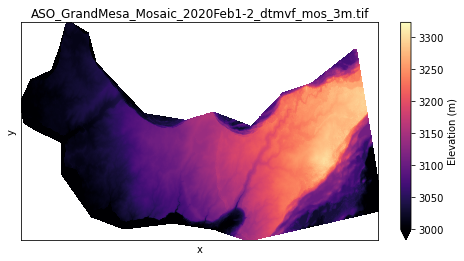

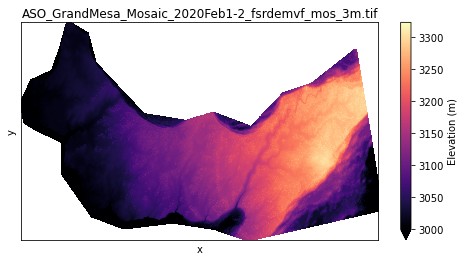

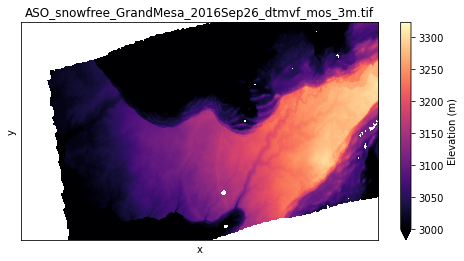

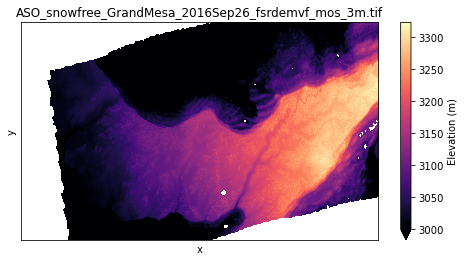

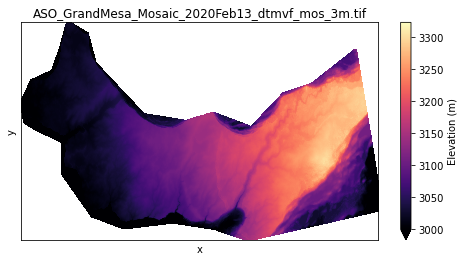

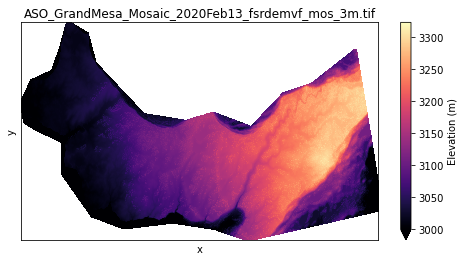

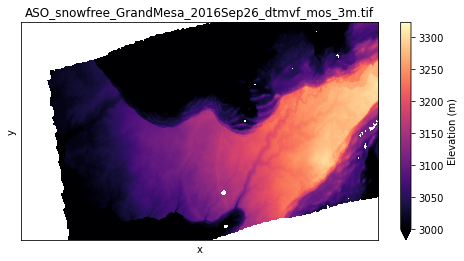

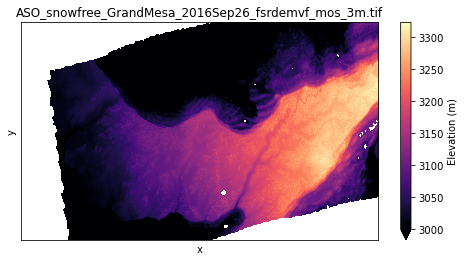

In [17]:
for dem, fn in zip(aso_dems, aso_fns):
    fig, ax = plt.subplots(1, figsize=(8, 4))
    ax.set_aspect('equal')
    dem.plot.imshow(vmin=vmin, vmax=vmax, cmap=cmap)
    
    ax.set_title(f'{os.path.basename(fn)}')
    ax.set_xticks(())
    ax.set_yticks(())

## Compare ASO depths with in situ points from pits, spirals, camera traps

## Write in situ points to raster files

## Use Snow-on dataset to co-register IS2 and compare DEMs

# Modification attempts from depth gallery

In [ ]:
from snowexsql.db import get_db
from snowexsql.data import ImageData, PointData
from snowexsql.conversions import raster_to_rasterio, points_to_geopandas, query_to_geopandas
from matplotlib.image import AxesImage
from rasterio.plot import show
from sqlalchemy.sql import func
import geoalchemy2.functions as gfunc
from geoalchemy2.types import Raster
from geoalchemy2.shape import to_shape, from_shape
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from shapely.geometry import Polygon, Point
import pandas as pd

In [ ]:
aso_depth = session.query(ImageData.surveyors, func.ST_PixelWidth(ImageData.raster)).filter(ImageData.type=='depth').distinct().all()
res = max([r[1] for r in aso_depth])
res = (res,res)
print('Using a resolution of {} m from {}'.format(res[0], aso_depth[0][0]))

In [ ]:
aso_swe = session.query(ImageData.surveyors, func.ST_PixelWidth(ImageData.raster)).filter(ImageData.type=='swe').distinct().all()
res = max([r[1] for r in aso_swe])
res = (res,res)
print('Using a resolution of {} m from {}'.format(res[0], aso_swe[0][0]))

In [ ]:
usgs_dem = session.query(ImageData.surveyors, func.ST_PixelWidth(ImageData.raster)).filter(ImageData.type=='DEM').distinct().all()
res = max([r[1] for r in usgs_dem])
res = (res,res)
print('Using a resolution of {} m from {}'.format(res[0], usgs_dem[0][0]))

In [ ]:
# Define a function to retrieve a resampled and clip dataset
def retrieve_matched_raster(data_name, surveyors, polygon, res, date=None):
    '''
    Gather all rasters filted by name and surveyors that intersect the polygon. Resample to the resolution provided
    and clip to the polygon
    '''

    # Retrieve the original resolution
    q =  session.query(func.ST_PixelWidth(ImageData.raster), func.ST_PixelHeight(ImageData.raster))
    res_o = q.filter(ImageData.type == data_name).filter(ImageData.surveyors == surveyors).limit(1).all()
    print('Original Resolution = {} x{}'.format(res_o[0][0], res_o[0][1]))

    # Return a tiff thats resampled the snow off to the same resolution as the Snow on and clip to the same extents
    s = func.ST_Clip(func.ST_Rescale(gfunc.ST_Union(ImageData.raster, type_=Raster), res[0], -1 * res[1],  'Bilinear'), polygon, True)

    # Filter by surveyors and data name DEM
    q = session.query(func.ST_AsTiff(s)).filter(ImageData.type == data_name)
    q = q.filter(ImageData.surveyors == surveyors)

#     # Grab all tile that intersect the snow on boundary
#     q = q.filter(gfunc.ST_Intersects(ImageData.raster, polygon))

    # Filter on a date if provided
    if date != None:
        q.filter(ImageData.date == date)

    records = q.all()

    # Convert to Rasterio
    dataset = raster_to_rasterio(session, records)[0]
    print('Raster {} X {}, Final Res = {} x {}'.format(dataset.width, dataset.height, dataset.res[0], dataset.res[1]))
    print(dataset.bounds)
    return dataset

# Define a convenient function to print out stats
def print_stats(img):
    for stat in ['mean','min','max','std']:
        fn = getattr(np, 'nan' + stat)
        print('\t{} = {}'.format(stat, fn(img)))

In [ ]:
res

In [ ]:
# Dictionary to hold rasterio datsets
rio = {}

# Dictionary to hold the numpy arrays
imgs = {}

# No Data as prescribed by metadata
# nodata = {'QSI':-3.4028234663852886e+38, 'USGS': -999999, 'ASO':-9999}
nodata = {'USGS': -999999, 'ASO':-9999}

# for surveyor in ['QSI', 'ASO', 'USGS']:
for surveyor in ['ASO', 'USGS']:
    print('\n{}:'.format(surveyor))
    args = ['DEM', surveyor, res]
    kwargs = {}

#     if surveyor == 'QSI':
#         kwargs['date'] = dt

    rio[surveyor] = retrieve_matched_raster(*args, **kwargs)
    img = rio[surveyor].read(1)
    if surveyor in nodata.keys():
        ind = img <= nodata[surveyor]
        img[ind] = np.nan
        ind = img == np.inf
        img[ind] = np.nan
    imgs[surveyor] = img

In [ ]:
# Pick a dataset
dataset = 'depth'

# Pick a date
collection_date = date(2020, 2, 7)

# The part inside the query function is what we want back, in this case all columns for the point data
qry = session.query(PointData)

# We then want to filter by the selected the data type depth.
qry = qry.filter(PointData.type == 'depth')

# Filter by a date
qry = qry.filter(PointData.date == collection_date)

# Limit it to a couple thousand 
qry = qry.limit(2000)

# Execute the query and convert to geopandas in one handy function
df = query_to_geopandas(qry, engine)

# how many did we retrieve?
print(f'{len(df.index)} records returned!')

In [ ]:
# Get the Matplotlib Axes object from the dataframe object, color the points by snow depth value
ax = df.plot(column='value', legend=True, cmap='PuBu')

# Use non-scientific notation for x and y ticks
ax.ticklabel_format(style='plain', useOffset=False)

# Set the various plots x/y labels and title.
ax.set_title(f'{len(df.index)} {dataset.title()}s collected on {collection_date.strftime("%Y-%m-%d")}')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')

In [ ]:
# Close the session to avoid hanging transactions
session.close()